In [2]:
# Get FTIR spectra from files
import sys
sys.path.append("..")
from toolkit.ascfile import read_asc
from glob import glob

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import basename
allfiles = glob("../raw_data/DataHenry/Perkin/**/*.asc", recursive=True)
dshape = len(allfiles), read_asc(allfiles[0]).shape[-1]
species = { "C": 0, "S": 1, "G": 2}
type = { "C": 0, "F": 1}
location = { "H10": 0, "N10": 1}
X = np.zeros(dshape)
Y = np.zeros((dshape[0], 4), dtype=np.uint32)
for i,f in enumerate(allfiles):
    data = read_asc(f)
    fname = basename(f)
    X[i, :] = data[1, :]
    Y[i, 0] = species[fname[1]]      # Espèce
    Y[i, 1] = int(fname[0])          # Process step
    Y[i, 2] = location[fname[3:6]]   # Location
    Y[i, 3] = type[fname[7:8]]       # Grain / Flesh


np.savez_compressed("perkin.npz", X=X, Y=Y, species=species, types=type, locations=location)

In [5]:
Y.shape, X.shape 

((362, 4), (362, 226))

In [21]:

dataset = np.load("perkin.npz")
X = dataset["X"][:, ::1]
Y = dataset["Y"]

In [22]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(in_features, 256)
        self.l2 = nn.Linear(256, 64)
        self.l3 = nn.Linear(64, out_features)
    def forward(self, X):
        X = torch.tanh(self.l1(X))
        X = torch.relu(self.l2(X))
        X = torch.tanh(self.l3(X))
        return X

class Decoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(in_features, 64)
        self.l2 = nn.Linear(64, 256)
        self.l3 = nn.Linear(256, out_features)

    def forward(self, X):
        X = torch.tanh(self.l1(X))
        X = torch.relu(self.l2(X))
        X = torch.tanh(self.l3(X))
        return X

class AutoEncoder(nn.Module):
    def __init__(self, features, latent_features=2, variationnal=False, smoothing=15):
        super(AutoEncoder, self).__init__()
        if variationnal:
            self.enc = Encoder(features, latent_features*2)
            self.dec = Decoder(latent_features, features+smoothing-1)
        else:
            self.enc = Encoder(features, latent_features)
            self.dec = Decoder(latent_features, features+smoothing-1)

        self.latent_features = latent_features
        self.variationnal = variationnal
        self.smoothing = smoothing
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=self.smoothing)
    def forward(self, X):
        bs = X.shape[0]
        if self.variationnal:
            X = self.enc(X).view(-1, 2, self.latent_features)
            mu = X[:, 0, :]
            logvar = (X[:, 1, :] - 1) * 5
            X = self.reparameterize(mu, logvar)
            return self.c1(self.dec(X).view(bs, 1, -1)).view(bs, -1), mu, logvar
        else:
            return self.c1(self.dec(self.enc(X)).view(bs, 1, -1)).view(bs, -1)
    
    def reconstruct(self, X):
        bs = X.shape[0]
        recons = self.dec(X).view(bs, 1, -1)
        recons = self.c1(recons)
        return (recons.view(bs, -1))
    
    def encode(self, X, std=False):
        code = self.enc(X)
        if self.variationnal:
            view = code.view(-1, 2, self.latent_features)
            if std:
                return view[:, 0, :], view[:, 1, :]
            else:
                return view[:, 0, :]
        else:
            return self.enc(X)

    def reparameterize(self, latent_mean, latent_logvar):
        std = torch.exp(0.5*latent_logvar)
        eps = torch.randn_like(std)
        sample = latent_mean + (eps * std)
        return sample

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)
from torch.utils.data import TensorDataset, DataLoader
loader = DataLoader(TensorDataset(torch.from_numpy(Xs).type(torch.float)), batch_size=8, shuffle=True)

In [24]:
mse_loss = nn.MSELoss()
ae = AutoEncoder(Xs.shape[1], 2, variationnal=True, smoothing=15)
from torch.optim import Adam
optim = Adam(ae.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 500
from tqdm import trange
progress_bar = trange(num_epochs)
for epoch in progress_bar:
    epoch_loss = 0.0
    for X_real, in loader:
        optim.zero_grad()
        Xp, mu, logvar = ae(X_real)
        recons_loss = mse_loss(Xp, X_real)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        (recons_loss+kld_loss*1e-6).backward()
        optim.step()

        epoch_loss += recons_loss.item()
    epoch_loss /= len(loader)
    progress_bar.set_description_str(f"{epoch_loss}")
    

0.0005978639440044113: 100%|██████████| 500/500 [01:35<00:00,  5.24it/s]


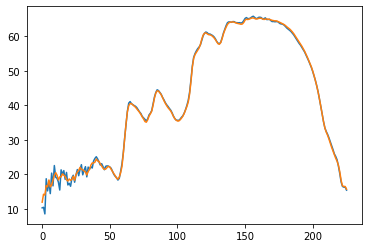

In [25]:
plt.plot(scaler.inverse_transform(X_real.detach().numpy())[1, :])
plt.plot(scaler.inverse_transform(Xp.detach().numpy())[1, :])

v = 3
X = 13
^ = 103
x = 113


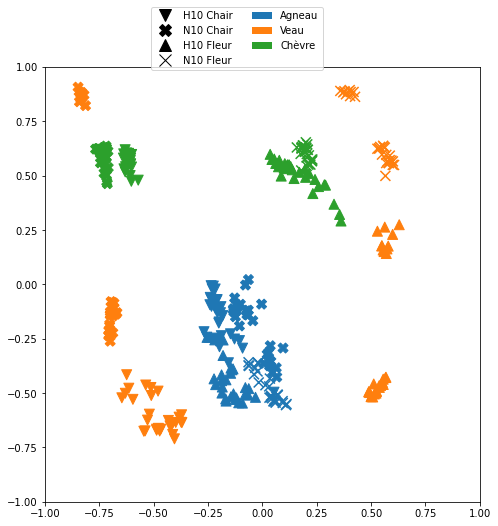

In [26]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
latent = ae.encode(torch.from_numpy(Xs).type(torch.float)).detach().numpy()

markers = ["v", "X", "^", "x"]
fig, ax = plt.subplots(figsize=(8,8))
markerlabel = np.array([ a  + b * 10 + c*100 for a, b, c in zip( Y[:, 1], Y[:, 2], Y[:, 3])]) # Process, Location, Side
for i, c in enumerate(np.unique(markerlabel)):
    print(markers[i], "=", c)
    mask = markerlabel == c
    cur = latent[mask,:]
    ax.scatter(*cur.T, c=[f"C{l}" for l in Y[mask, 0].flat], marker=markers[i], s=100)
legend_elements = [Line2D([0], [0], marker="v", markersize=12, color='k', linestyle="", label='H10 Chair'),
                   Line2D([0], [0], marker="X", markersize=12, color='k', linestyle="", label='N10 Chair'),
                   Line2D([0], [0], marker='^', color='k', linestyle="", label='H10 Fleur', markersize=12),
                   Line2D([0], [0], marker='x', color='k', linestyle="", label='N10 Fleur', markersize=12),
                   Patch(facecolor='C0',  label='Agneau'),
                   Patch(facecolor='C1',  label='Veau'),
                   Patch(facecolor='C2',  label='Chèvre'),
                   ]
                
plt.axis("square")
plt.axis([-1, 1, -1, 1])
plt.legend(handles=legend_elements, bbox_to_anchor =(0.65, 1.15), ncol=2)